In [ ]:
!pip install segmentation_models_pytorch
!pip install wandb

# Iniatial

In [2]:
!mkdir Master
!mkdir Master/IMD2020

!wget -P Master/IMD2020 https://staff.utia.cas.cz/novozada/db/IMD2020.zip

--2024-03-26 22:35:58--  https://staff.utia.cas.cz/novozada/db/IMD2020.zip
Resolving staff.utia.cas.cz (staff.utia.cas.cz)... 147.231.16.197
Connecting to staff.utia.cas.cz (staff.utia.cas.cz)|147.231.16.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 592836398 (565M) [application/zip]
Saving to: ‘Master/IMD2020/IMD2020.zip’

IMD2020.zip         100%[===================>] 565.37M  10.6MB/s    in 2m 31s  

2024-03-26 22:38:30 (3.75 MB/s) - ‘Master/IMD2020/IMD2020.zip’ saved [592836398/592836398]



In [3]:
!unzip /content/Master/IMD2020/IMD2020.zip -d Master/IMD2020

Archive:  /content/Master/IMD2020/IMD2020.zip
   creating: Master/IMD2020/1a1ogs/
  inflating: Master/IMD2020/1a1ogs/1a1ogs_orig.jpg  
  inflating: Master/IMD2020/1a1ogs/c8tf5mq_0.png  
  inflating: Master/IMD2020/1a1ogs/c8tf5mq_0_mask.png  
   creating: Master/IMD2020/1a3oag/
  inflating: Master/IMD2020/1a3oag/1a3oag_orig.jpg  
  inflating: Master/IMD2020/1a3oag/c8tt7fg_0.jpg  
  inflating: Master/IMD2020/1a3oag/c8tt7fg_0_mask.png  
  inflating: Master/IMD2020/1a3oag/c8ttni9_0.jpg  
  inflating: Master/IMD2020/1a3oag/c8ttni9_0_mask.png  
  inflating: Master/IMD2020/1a3oag/c8ttxcu_0.jpg  
  inflating: Master/IMD2020/1a3oag/c8ttxcu_0_mask.png  
  inflating: Master/IMD2020/1a3oag/c8ttxi0_0.jpg  
  inflating: Master/IMD2020/1a3oag/c8ttxi0_0_mask.png  
  inflating: Master/IMD2020/1a3oag/c8tvsnn_0.jpg  
  inflating: Master/IMD2020/1a3oag/c8tvsnn_0_mask.png  
  inflating: Master/IMD2020/1a3oag/c8twn73_0.jpg  
  inflating: Master/IMD2020/1a3oag/c8twn73_0_mask.png  
  inflating: Master/IMD2020

In [4]:
# !unzip /content/Master/annotations/panoptic_val2017.zip -d Master
# !mv /content/Master/annotations/panoptic_val2017.json /content/Master # move src dest
# !mv /content/Master/instances/annotations/instances_val2017.json /content/Master # move src dest
# # !unzip /content/Master/panoptic_annotations_trainval2017.zip -d Master

!rm -r /content/Master/IMD2020/IMD2020.zip

# !unzip /content/Master/annotations/panoptic_train2017.zip -d Master
# !mv /content/Master/annotations/panoptic_train2017.json /content/Master # move src dest
# !mv /content/Master/instances/annotations/instances_train2017.json /content/Master # move src dest

In [5]:
# import shutil

# shutil.rmtree('/content/Master', ignore_errors=True)

# Libraries

In [6]:
# For managing COCO dataset
# from pycocotools.coco import COCO

# For creating and managing folder/ files
import glob
import os
import shutil

# For managing images
from PIL import Image
import skimage.io as io

# Basic libraries
import numpy as np
import pandas as pd
import random
import cv2

# For plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# For importing models and working with them
## Torch
import torch
import torch.utils.data # for Dataset
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

## Torchvision
import torchvision
from torchvision.transforms import transforms

# For creating train - test splits
from sklearn.model_selection import train_test_split

import pathlib
import pylab
import requests
from io import BytesIO
from pprint import pprint
from tqdm import tqdm
import time
from imutils import paths

# Performance Metrics
from sklearn.metrics import multilabel_confusion_matrix


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# %matplotlib inline

cuda


# Configuration

In [ ]:
# data = 'train2017'

# # Data and Masks
# IMAGE_PATH = os.path.join('/content/Master/', data)
# MASK_PATH = os.path.join('/content/Master/', 'panoptic_' + data)

# # define the path to the base output directory
# BASE_OUTPUT = '/content/Master/Output'

# # define the path to the output serialized model, model training plot, and testing image paths
# MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
# PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
# TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])



# # determine if we will be pinning memory during data loading
# PIN_MEMORY = True if device == "cuda" else False


# # define the number of channels in the input, number of classes, and number of levels in the U-Net model
# # NUM_CHANNELS = 3
# # NUM_CLASSES = 2 # person vs Background

# # define the input image dimensions
# INPUT_IMAGE_WIDTH = 256
# INPUT_IMAGE_HEIGHT = 256

# # define threshold to filter weak predictions
# THRESHOLD = 0.5 # for binary classification

# Functions

In [ ]:
def gen_binary_mask (img, coco, anns):
  mask = np.zeros((img['height'], img['width']))

  for i in range(len(anns)):

      mask = np.maximum(mask, coco.annToMask(anns[i]) * anns[i]['category_id'] )

  return mask


In [ ]:
def calculate_metrics(gt_masks, pred_masks):
    tp = 0  # true positive
    tn = 0  # true negative
    fp = 0  # false positive
    fn = 0  # false negative

    for gt_mask, pred_mask in zip(gt_masks, pred_masks):
        gt_mask = gt_mask.flatten()
        pred_mask = pred_mask.flatten()

        tp += np.sum(np.logical_and(pred_mask == 1, gt_mask == 1))
        tn += np.sum(np.logical_and(pred_mask == 0, gt_mask == 0))
        fp += np.sum(np.logical_and(pred_mask == 1, gt_mask == 0))
        fn += np.sum(np.logical_and(pred_mask == 0, gt_mask == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

In [ ]:
def calculate_dice_coefficient(gt_masks, pred_masks):
    intersection = np.logical_and(gt_masks, pred_masks)
    dice_coefficient = (2.0 * intersection.sum()) / (gt_masks.sum() + pred_masks.sum())
    return dice_coefficient

def calculate_iou(gt_masks, pred_masks):
    intersection = np.logical_and(gt_masks, pred_masks)
    union = np.logical_or(gt_masks, pred_masks)
    iou = intersection.sum() / union.sum()
    return iou

In [ ]:
def train_model(model, dataloader, steps, loss_function, optim, device):
  print("Training...")

  model.train()

  totalTrainLoss = 0

  # loop over the training set
  for i, (x, y) in enumerate(dataloader):

      # send the input to the device
      (x, y) = (x.to(device), y.to(device))

      # perform a forward pass and calculate the training loss
      pred = model(x)
      loss = loss_function(pred, y)

      # first, zero out any previously accumulated gradients, then
      # perform backpropagation, and then update model parameters
      optim.zero_grad()
      loss.backward()
      optim.step()

      # add the loss to the total training loss so far
      totalTrainLoss += loss


  avgTrainLoss = totalTrainLoss / steps

  return avgTrainLoss

In [ ]:
def validate_model(model, dataloader, steps, loss_function, optim, device):
  print("Validating...")

  model.eval()

  totalTrainLoss = 0

  # loop over the training set
  with torch.no_grad():
    for i, (x, y) in enumerate(dataloader):

        # send the input to the device
        (x, y) = (x.to(device), y.to(device))

        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = loss_function(pred, y)

        # add the loss to the total training loss so far
        totalTrainLoss += loss


    avgTrainLoss = totalTrainLoss / steps

    return avgTrainLoss

## Dataset

In [ ]:
class SegmentationDataset(Dataset):

    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms


    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)


    def __getitem__(self, idx):

        image = Image.open(self.imagePaths[idx]).convert("RGB")
        mask = Image.open(self.maskPaths[idx]).convert("L")

        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)


        # return a tuple of the image and its mask
        return (image, mask)

# Data

## Data Preparation

In [61]:
from torch.utils.data import Dataset
from PIL import Image

class SegmentationDataset(Dataset):

    def __init__(self, original_images, altered_images, masks, transforms=None):
        self.original_images = original_images
        self.altered_images = altered_images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.original_images)

    def __getitem__(self, idx):
        original_image = self.original_images[idx]
        altered_image = self.altered_images[idx]
        mask = self.masks[idx]

        if self.transforms:
            original_image = self.transforms(original_image)
            altered_image = self.transforms(altered_image)
            mask = self.transforms(mask)

        return original_image, altered_image, mask

def load_dataset(dataset_path, num_folders):
    print("Starting loading dataset")
    original_images = []
    altered_images = []
    masks = []

    folders = sorted(os.listdir(dataset_path))[:num_folders]
    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            # Find the common ID from the filenames
            common_id = None
            for file in os.listdir(folder_path):
                if file.endswith('_0.jpg') or file.endswith('_0.png'):
                    common_id = file.split('_')[0]  # Extract common ID from filename
                    break  # Stop after finding the first _0.jpg or _0.png file

            if common_id is None:
                print(f"No altered image found for folder {folder}")
                continue

            # Construct file paths for original image, altered image, and mask
            orig_path = os.path.join(folder_path, folder+'_orig.jpg')
            altered_ext = 'jpg' if os.path.exists(os.path.join(folder_path, common_id+'_0.jpg')) else 'png'
            altered_path = os.path.join(folder_path, common_id+'_0.'+altered_ext)
            mask_path = os.path.join(folder_path, common_id+'_0_mask.png')

            try:
                orig_img = Image.open(orig_path).convert("RGB")
                altered_img = Image.open(altered_path).convert("RGB")
                mask_img = Image.open(mask_path).convert("L")  # Convert to grayscale

                if orig_img is None or altered_img is None or mask_img is None:
                    print(f"Failed to load images for folder {folder}")
                    continue

                original_images.append(orig_img)
                altered_images.append(altered_img)
                masks.append(mask_img)
            except Exception as e:
                print(f"Error loading images for folder {folder}: {e}")

    return original_images, altered_images, masks

# Example usage:
dataset_path = '/content/Master/IMD2020'
num_folders = 100  # Number of folders to read
original_images, altered_images, masks = load_dataset(dataset_path, num_folders)

# You can apply any transformations needed before creating the dataset
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create the dataset
dataset = SegmentationDataset(original_images, altered_images, masks, transforms=transforms_train)


Starting loading dataset


In [103]:
# dataset.masks[0]

In [97]:
# import torch
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as TF

# def visualize_images(original_images, altered_images, masks, pred_masks, num_samples=3, figsize=(15, 15), threshold = 0.4):


#     for i in range(num_samples):
#         plt.figure(figsize=figsize)

#         # orig_rgb = TF.to_pil_image(original_images[i])
#         # altered_rgb = TF.to_pil_image(altered_images[i])

#         # Plot original image
#         plt.subplot(141)
#         plt.imshow(original_images[i].permute(1, 2, 0))
#         plt.title('Original Image')
#         plt.axis('off')

#         # Plot altered image
#         plt.subplot(142)
#         plt.imshow(altered_images[i].permute(1, 2, 0))
#         plt.title('Altered Image')
#         plt.axis('off')

#         # Plot ground truth mask
#         plt.subplot(143)
#         plt.imshow(masks[i][0], cmap='gray')
#         plt.title('Ground Truth Mask')
#         plt.axis('off')

#         # Plot predicted mask (binary)
#         # plt.subplot(144)

#         # flat_pred_masks = pred_masks.flatten()
#         # sorted_values = torch.sort(flat_pred_masks, descending=True).values
#         # tenth_highest_value = sorted_values[9]

#         # binary_pred_mask = (torch.sigmoid(pred_masks[i][0]).cpu() < tenth_highest_value).numpy()

#         # plt.imshow(binary_pred_mask, cmap='gray', vmin=0, vmax=255)
#         # plt.title('Predicted Mask (Binary)')
#         # plt.axis('off')

#         plt.subplot(144)
#         plt.imshow(pred_masks[i][0].detach().cpu().numpy(), cmap='gray')  # Detach and convert to NumPy array
#         plt.title('Predicted Mask')
#         plt.axis('off')

#         # Adjust layout to prevent overlap
#         plt.tight_layout()

#         # Display the plot
#         plt.show()


def calculate_metrics(gt_masks, pred_masks):
    tp = 0  # true positive
    tn = 0  # true negative
    fp = 0  # false positive
    fn = 0  # false negative

    for gt_mask, pred_mask in zip(gt_masks, pred_masks):
        gt_mask = gt_mask.flatten()
        pred_mask = pred_mask.flatten()

        tp += np.sum(np.logical_and(pred_mask == 1, gt_mask == 1))
        tn += np.sum(np.logical_and(pred_mask == 0, gt_mask == 0))
        fp += np.sum(np.logical_and(pred_mask == 1, gt_mask == 0))
        fn += np.sum(np.logical_and(pred_mask == 0, gt_mask == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score


def calculate_dice_coefficient(gt_masks, pred_masks):
    intersection = np.logical_and(gt_masks, pred_masks)
    dice_coefficient = (2.0 * intersection.sum()) / (gt_masks.sum() + pred_masks.sum())
    return dice_coefficient

def calculate_iou(gt_masks, pred_masks):
    intersection = np.logical_and(gt_masks, pred_masks)
    union = np.logical_or(gt_masks, pred_masks)
    iou = intersection.sum() / union.sum()
    return iou


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Dataset length: 100
[INFO] TEST_SPLIT = 0.3 ...
Splits, Datasets, and Dataloaders
[INFO] Total time taken to create the dataset and dataloader: 0.00s
[INFO] found 100 examples in the training set...


accuracy,▁▄▆▆▇▇████
loss,▁▂▃▄▅▅▆▇▇█
precision,▁▂▄▅▆▇▇▇██
accuracy,1.11057
loss,7.00936
precision,0.99835


[INFO] Training the network for 10 epochs...


 10%|█         | 1/10 [00:04<00:42,  4.74s/it]

[INFO] EPOCH: 1/10
Train loss: 7.627006


 20%|██        | 2/10 [00:09<00:39,  4.98s/it]

[INFO] EPOCH: 2/10
Train loss: 8.182243


 30%|███       | 3/10 [00:15<00:35,  5.13s/it]

[INFO] EPOCH: 3/10
Train loss: 8.672604


 40%|████      | 4/10 [00:19<00:29,  4.95s/it]

[INFO] EPOCH: 4/10
Train loss: 9.111765


 50%|█████     | 5/10 [00:25<00:25,  5.05s/it]

[INFO] EPOCH: 5/10
Train loss: 9.506957


 60%|██████    | 6/10 [00:29<00:19,  4.93s/it]

[INFO] EPOCH: 6/10
Train loss: 9.864156


 70%|███████   | 7/10 [00:34<00:15,  5.01s/it]

[INFO] EPOCH: 7/10
Train loss: 10.215252


 80%|████████  | 8/10 [00:39<00:09,  4.90s/it]

[INFO] EPOCH: 8/10
Train loss: 10.524203


 90%|█████████ | 9/10 [00:45<00:05,  5.34s/it]

[INFO] EPOCH: 9/10
Train loss: 10.809573


100%|██████████| 10/10 [00:50<00:00,  5.09s/it]

[INFO] EPOCH: 10/10
Train loss: 11.083998
[INFO] Total time taken to train the model: 50.93s


Average accuracy = 109.00000000000001%
Average precision = 73.0%
Average recall = 54.0%
Average f1_score = 109.00000000000001%
Average DICE = 61.0%
Average IOU = 43.0%




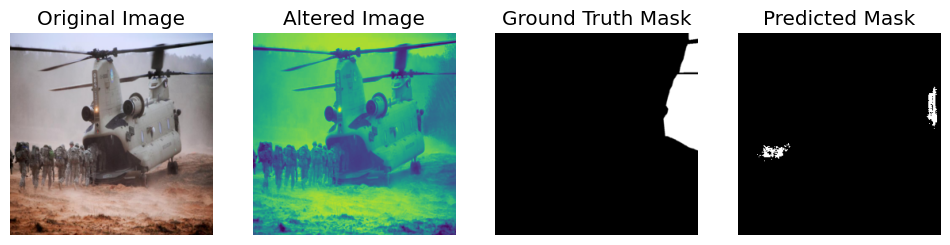

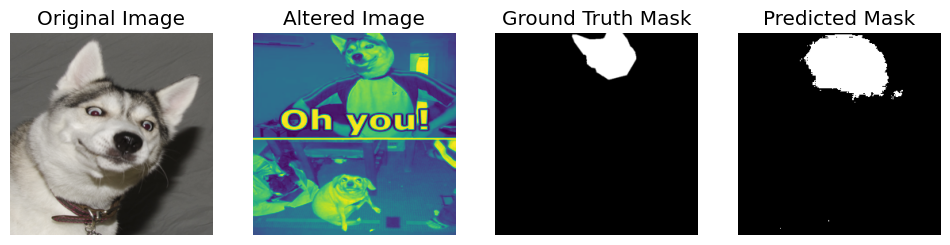

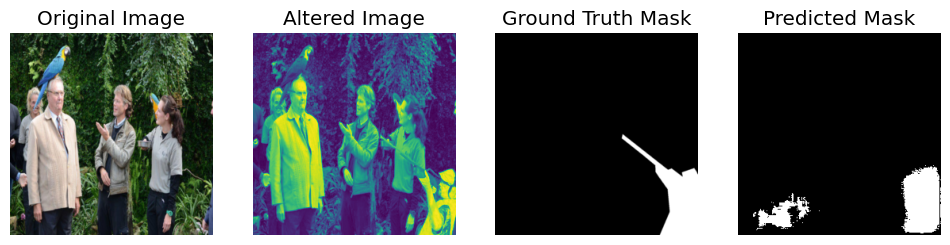

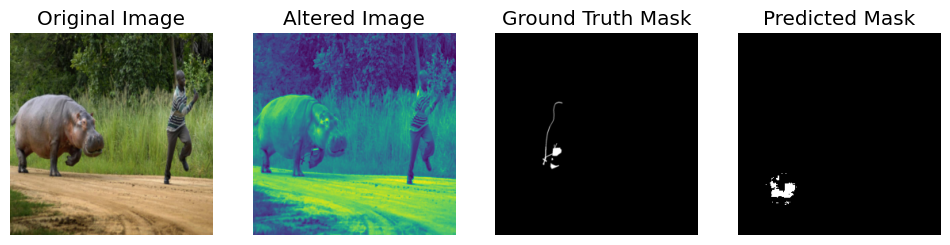

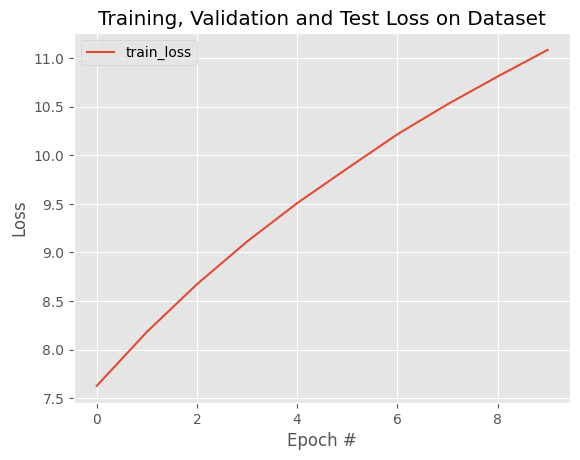

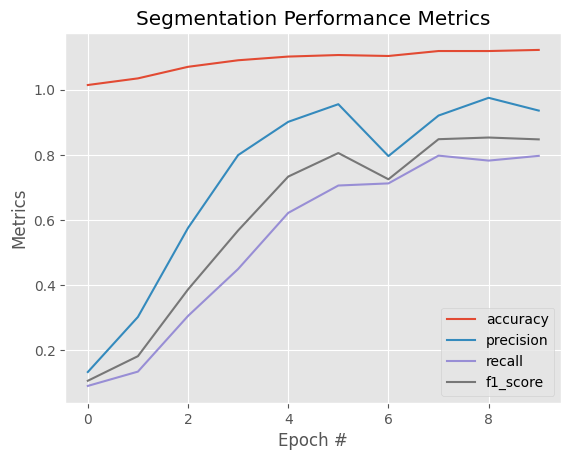

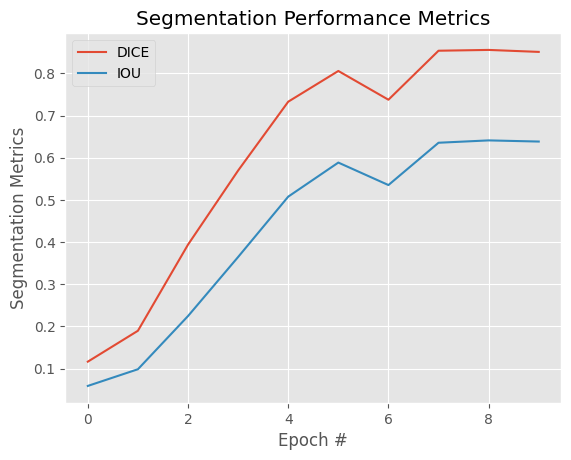

accuracy,▁▂▅▆▇▇▇███
loss,▁▂▃▄▅▆▆▇▇█
precision,▁▂▅▇▇█▇███
accuracy,1.12223
loss,11.084
precision,0.93609


[INFO] Training the network for 20 epochs...


  5%|▌         | 1/20 [00:04<01:33,  4.94s/it]

[INFO] EPOCH: 1/20
Train loss: 11.337129


 10%|█         | 2/20 [00:10<01:31,  5.11s/it]

[INFO] EPOCH: 2/20
Train loss: 11.575116


 15%|█▌        | 3/20 [00:14<01:23,  4.90s/it]

[INFO] EPOCH: 3/20
Train loss: 11.804095


 20%|██        | 4/20 [00:19<01:18,  4.90s/it]

[INFO] EPOCH: 4/20
Train loss: 12.028121


 25%|██▌       | 5/20 [00:24<01:14,  4.94s/it]

[INFO] EPOCH: 5/20
Train loss: 12.247531


 30%|███       | 6/20 [00:30<01:11,  5.13s/it]

[INFO] EPOCH: 6/20
Train loss: 12.455878


 35%|███▌      | 7/20 [00:38<01:21,  6.29s/it]

[INFO] EPOCH: 7/20
Train loss: 12.649061


 35%|███▌      | 7/20 [00:39<01:14,  5.71s/it]


KeyboardInterrupt: 

In [100]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb

wandb.login()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the U-Net model
unet = smp.Unet(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,  # Assuming 3 channels for both original and altered images
    classes=1  # Output classes (1 for mask)
).to(device)

# Define hyperparameters
INIT_LR = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = [10, 20, 50, 100, 150]
TEST_SPLIT = [0.3]
VALID_SPLIT = 0.1

# Initialize loss function and optimizer
lossFunc = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(unet.parameters(), lr=INIT_LR)

# Define transformations for test (optional)
transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create DataLoader for the dataset
trainLoader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
print("Dataset length:", len(trainLoader.dataset))

# Calculate steps per epoch for training set
trainSteps = len(trainLoader)

for tts in TEST_SPLIT:
    print("[INFO] TEST_SPLIT = {} ...".format(tts))

    print("Splits, Datasets, and Dataloaders")
    startTime = time.time()

    train_orig_images, test_orig_images, train_altered_images, test_altered_images, train_masks, test_masks = train_test_split(original_images, altered_images, masks, test_size=TEST_SPLIT, random_state=42)
    train_orig_images, val_orig_images, train_altered_images, val_altered_images, train_masks, val_masks = train_test_split(train_orig_images, train_altered_images, train_masks, test_size=VALID_SPLIT, random_state=42)

    # Create datasets and data loaders for training, validation, and testing sets
    train_dataset = SegmentationDataset(train_orig_images, train_altered_images, train_masks, transforms=transforms_train)
    val_dataset = SegmentationDataset(val_orig_images, val_altered_images, val_masks, transforms=transforms_test)
    test_dataset = SegmentationDataset(test_orig_images, test_altered_images, test_masks, transforms=transforms_test)

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)


    endTime = time.time()
    print("[INFO] Total time taken to create the dataset and dataloader: {:.2f}s".format(endTime - startTime))

    print(f"[INFO] found {len(dataset)} examples in the training set...")

    # calculate steps per epoch for training set
    trainSteps = len(train_dataset) // BATCH_SIZE
    testSteps = len(test_dataset) // BATCH_SIZE
    valSteps = len(val_dataset) // BATCH_SIZE

    for epoch in NUM_EPOCHS:

        run = wandb.init(
                      # Set the project where this run will be logged
                      project = "my-project",
                      # Track hyperparameters and run metadata
                      config={
                          "learning_rate": INIT_LR,
                          "epochs": epoch,
                          "batch": BATCH_SIZE
                      },
                      )

        # Initialize dictionary to store training history
        H = {"train_loss": []}
        Perf_Metrics = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}
        Dice_IOU = {"dice": [], "iou": []}

        print("[INFO] Training the network for {} epochs...".format(epoch))

        startTime = time.time()

        for e in tqdm(range(epoch)):

            # initialize variables for output
            totalTrainLoss, totalTestLoss, totalValLoss = 0
            accuracy_scores, precision_score, recall_scores, f1_scores = 0, 0, 0, 0
            dice_scores, iou_scores = 0, 0

            # Training loop
            unet.train()
            for orig_images, altered_images, masks in train_loader:
                images, altered_images, masks = images.to(device), altered_images.to(device), masks.to(device)

                opt.zero_grad()
                pred_masks = unet(images) # they are not binary => the binary masks are displayed using the vizualize function with a threshold
                # pred_masks = torch.sigmoid(pred_masks)

                loss = lossFunc(pred_masks, masks)
                loss.backward()
                opt.step()

                pred_masks = (pred_masks > 0.5).float()

                totalTrainLoss += loss.item()

            avg_train_loss = totalTrainLoss / len(train_loader)


            # Validate the model
            unet.eval()
            with torch.no_grad():
                total_val_loss = 0
                for orig_images, altered_images, masks in val_loader:
                    orig_images, altered_images, masks = orig_images.to(device), altered_images.to(device), masks.to(device)
                    pred_masks = unet(orig_images)
                    val_loss = lossFunc(pred_masks, masks)

                    totalValLoss += val_loss.item()

            avg_val_loss = totalValLoss / len(val_loader)

            # Log the losses to WandB
            wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "epoch": e})

            unet.eval()
            with torch.no_grad():
                for orig_images, altered_images, masks in test_loader:
                    orig_images, altered_images, masks = orig_images.to(device), altered_images.to(device), masks.to(device)
                    pred_masks = unet(orig_images)


                    # calculate Dice coefficient and IoU score
                    metrics = calculate_metrics(masks.cpu().numpy(), pred_masks.cpu().numpy())
                    accuracy, precision, recall, f1_score = metrics

                    dice_coefficient = calculate_dice_coefficient(masks.cpu().numpy(), pred_masks.cpu().numpy())
                    iou = calculate_iou(masks.cpu().numpy(), pred_masks.cpu().numpy())

                    # avg metrics
                    accuracy_scores += accuracy
                    precision_score += precision
                    recall_scores += recall
                    f1_scores += f1_score

                    dice_scores += dice_coefficient
                    iou_scores += iou


                # visualize_images(images.cpu(), altered_images.cpu(), masks.cpu(), pred_masks.cpu()) #, threshold = tenth_highest_value)

            avgTrainLoss = totalTrainLoss / trainSteps
            avgValLoss = totalValLoss / valSteps
            avgTestLoss = totalTestLoss / testSteps

            # Update training history
            accuracy_scores = accuracy_scores / testSteps #testSteps
            precision_score = precision_score / testSteps
            recall_scores = recall_scores / testSteps
            f1_scores = f1_scores / testSteps

            dice_scores = dice_scores / testSteps
            iou_scores = iou_scores / testSteps

            # update our training history
            H["train_loss"].append(avgTrainLoss)
            H["val_loss"].append(avgValLoss)
            H["test_loss"].append(avgTestLoss)

            # update our performance metrics history
            Perf_Metrics["accuracy"].append(accuracy_scores)
            Perf_Metrics["precision"].append(precision_score)
            Perf_Metrics["recall"].append(recall_scores)
            Perf_Metrics["f1_score"].append(f1_scores)


            # update our dice and IOU score history
            Dice_IOU["dice"].append(dice_scores)
            Dice_IOU["iou"].append(iou_scores)

            # Print training loss
            print("[INFO] EPOCH: {}/{}".format(e + 1, epoch))
            print("Train loss: {:.6f}".format(avgTrainLoss))

            wandb.log({"accuracy": accuracy_scores, "precision": precision_score, "loss": avgTrainLoss})

        # Display total time taken to perform the training
        endTime = time.time()
        print("[INFO] Total time taken to train the model: {:.2f}s".format(endTime - startTime))

        print('\n')

        print("Average accuracy = {}%".format(100 * round(sum(Perf_Metrics["accuracy"])/len(Perf_Metrics["accuracy"]), 2)))
        print("Average precision = {}%".format(100 * round(sum(Perf_Metrics["precision"])/len(Perf_Metrics["precision"]), 2)))
        print("Average recall = {}%".format(100 * round(sum(Perf_Metrics["recall"])/len(Perf_Metrics["recall"]), 2)))
        print("Average f1_score = {}%".format(100 * round(sum(Perf_Metrics["accuracy"])/len(Perf_Metrics["f1_score"]), 2)))

        print("Average DICE = {}%".format(100 * round(sum(Dice_IOU["dice"])/len(Dice_IOU["dice"]), 2)))
        print("Average IOU = {}%".format(100 * round(sum(Dice_IOU["iou"])/len(Dice_IOU["iou"]), 2)))

        print('\n')


        lent = images.cpu().numpy().shape[0]

        for i in range (0, lent):
          plt.figure(figsize = (12, 12))

          # plot original image
          plt.subplot(141)
          plt.imshow(images.cpu().numpy()[i].transpose(1, 2, 0))
          plt.title('Original Image')
          plt.axis('off')

          # plot ground truth mask
          plt.subplot(142)
          plt.imshow(altered_images.cpu().numpy()[i][0])
          plt.title('Altered Image')
          plt.axis('off')

          # plot predicted mask
          plt.subplot(143)
          plt.imshow(masks.cpu().numpy()[i][0], cmap='gray')
          plt.title('Ground Truth Mask')
          plt.axis('off')

          # plot predicted mask
          plt.subplot(144)
          plt.imshow(pred_masks.cpu().numpy()[i][0], cmap='gray')
          plt.title('Predicted Mask')
          plt.axis('off')

          # display the plot
          plt.show()


        # plot the training loss
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(H["train_loss"], label = "train_loss")
        # plt.plot(H["val_loss"], label="val_loss")
        # plt.plot(H["test_loss"], label="test_loss")
        plt.title("Training, Validation and Test Loss on Dataset")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


        ##### NOT FOR NOW ######
        # plot the performance metrics
        # plt.style.use("ggplot")
        # plt.figure()
        # plt.plot(Perf_Metrics["accuracy"], label = "accuracy")
        # plt.plot(Perf_Metrics["precision"], label="precision")
        # plt.plot(Perf_Metrics["recall"], label="recall")
        # plt.plot(Perf_Metrics["f1_score"], label="f1_score")

        # plt.title("Segmentation Performance Metrics")
        # plt.xlabel("Epoch #")
        # plt.ylabel("Metrics")
        # plt.legend()
        # plt.show()


        # # plot the performance metrics
        # plt.style.use("ggplot")
        # plt.figure()
        # plt.plot(Dice_IOU["dice"], label = "DICE")
        # plt.plot(Dice_IOU["iou"], label="IOU")

        # plt.title("Segmentation Performance Metrics")
        # plt.xlabel("Epoch #")
        # plt.ylabel("Segmentation Metrics")
        # plt.legend()
        # plt.show()

        print('\n')


In [10]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
# import segmentation_models_pytorch as smp
# import time
# from tqdm import tqdm

# # Define device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initialize the U-Net model
# unet = smp.Unet(
#     encoder_name="resnet101",
#     encoder_weights="imagenet",
#     in_channels=3,  # Assuming 3 channels for both original and altered images
#     classes=1  # Output classes (1 for mask)
# ).to(device)

# # Define hyperparameters
# INIT_LR = 0.0001
# BATCH_SIZE = 32
# NUM_EPOCHS = [10, 20, 50, 100, 150]
# TEST_SPLIT = [0.3]
# VALID_SPLIT = 0.1

# # Initialize loss function and optimizer
# lossFunc = nn.BCEWithLogitsLoss()
# opt = torch.optim.Adam(unet.parameters(), lr=INIT_LR)

# # Define transformations for test (optional)
# transforms_test = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
# ])

# # Create DataLoader for the dataset
# trainLoader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

# # Calculate steps per epoch for training set
# trainSteps = len(trainLoader)

# for tts in TEST_SPLIT:
#     print("[INFO] TEST_SPLIT = {} ...".format(tts))

#     print("Splits, Datasets and Dataloaders")
#     startTime = time.time()

#     # Dummy split for testing (using the whole dataset)
#     trainImages = original_images
#     trainAlteredImages = altered_images
#     trainMasks = masks

#     # Create the training dataset
#     trainDS = SegmentationDataset(original_images=trainImages, altered_images=trainAlteredImages, masks=trainMasks, transforms=transforms_train)

#     # Create the training data loader
#     trainLoader = DataLoader(trainDS, shuffle=True, batch_size=BATCH_SIZE)

#     endTime = time.time()
#     print("[INFO] Total time taken to create the dataset and dataloader: {:.2f}s".format(endTime - startTime))

#     print(f"[INFO] found {len(trainDS)} examples in the training set...")

#     # calculate steps per epoch for training set
#     trainSteps = len(trainDS) // BATCH_SIZE

#     for epoch in NUM_EPOCHS:
#         # Initialize dictionary to store training history
#         H = {"train_loss": []}

#         print("[INFO] Training the network for {} epochs...".format(epoch))

#         startTime = time.time()

#         for e in tqdm(range(epoch)):
#             totalTrainLoss = 0

#             # Training loop
#             unet.train()
#             for images, altered_images, masks in trainLoader:
#                 images, altered_images, masks = images.to(device), altered_images.to(device), masks.to(device)

#                 opt.zero_grad()
#                 pred_masks = unet(images)
#                 loss = lossFunc(pred_masks, masks)
#                 loss.backward()
#                 opt.step()

#                 totalTrainLoss += loss.item()

#                 # Visualize images
#                 visualize_images(images.cpu(), altered_images.cpu(), masks.cpu(), torch.sigmoid(pred_masks).cpu())

#             avgTrainLoss = totalTrainLoss / trainSteps

#             # Update training history
#             H["train_loss"].append(avgTrainLoss)

#             # Print training loss
#             print("[INFO] EPOCH: {}/{}".format(e + 1, epoch))
#             print("Train loss: {:.6f}".format(avgTrainLoss))

#         # Display total time taken to perform the training
#         endTime = time.time()
#         print("[INFO] Total time taken to train the model: {:.2f}s".format(endTime - startTime))

#         # Plot training loss
#         plt.plot(H["train_loss"], label="train_loss")
#         plt.title("Training Loss")
#         plt.xlabel("Epoch")
#         plt.ylabel("Loss")
#         plt.legend()
#         plt.show()

[INFO] TEST_SPLIT = 0.3 ...
Splits, Datasets and Dataloaders
[INFO] Total time taken to create the dataset and dataloader: 0.00s
[INFO] found 100 examples in the training set...
[INFO] Training the network for 10 epochs...


  0%|          | 0/10 [00:00<?, ?it/s]


IndexError: index 55 is out of bounds for dimension 0 with size 32